In [25]:
import os
import numpy as np
import random
import pandas as pd
import geopandas
import contextily as cx
from datetime import date
import matplotlib.pyplot as plt

# Loading snapshots
- Consists of 11497 pollution maps generated with ADMS-Urban
- each has 79053 component entries
- they corresponds to a time serie from 06/07/2017 00:00 to 26/11/2018 23:00

In [2]:
# Load snapshots
data = np.load('./pollution_data/concentration_fields_NO2.npy')
ns, ndof = data.shape

In [127]:
# Check sizes
print('Number of snapshots: {}'.format(ns))
print('Snapshot dofs: {}'.format(ndof))

# Check dates
d0 = date(2017,  7,  6)
d1 = date(2018, 11, 26)
period = d1 - d0
hours_snap = period.days * 24
print('Expected: # snapshots hours {}'.format(hours_snap))

Number of snapshots: 11497
Snapshot dofs: 79053
Expected: # snapshots hours 12192


In [4]:
mesh = np.loadtxt('./pollution_data/mesh-coordinates.txt')
xmax, ymax = np.max(mesh[:,0]), np.max(mesh[:,1])
print('xmax={}, ymax={}'.format(xmax, ymax))

# Max concentration
cmax = np.max(data)
print('cmax={}'.format(cmax))

xmax=660900.0, ymax=6867046.0
cmax=929.007


## Plot snapshot

No handles with labels found to put in legend.


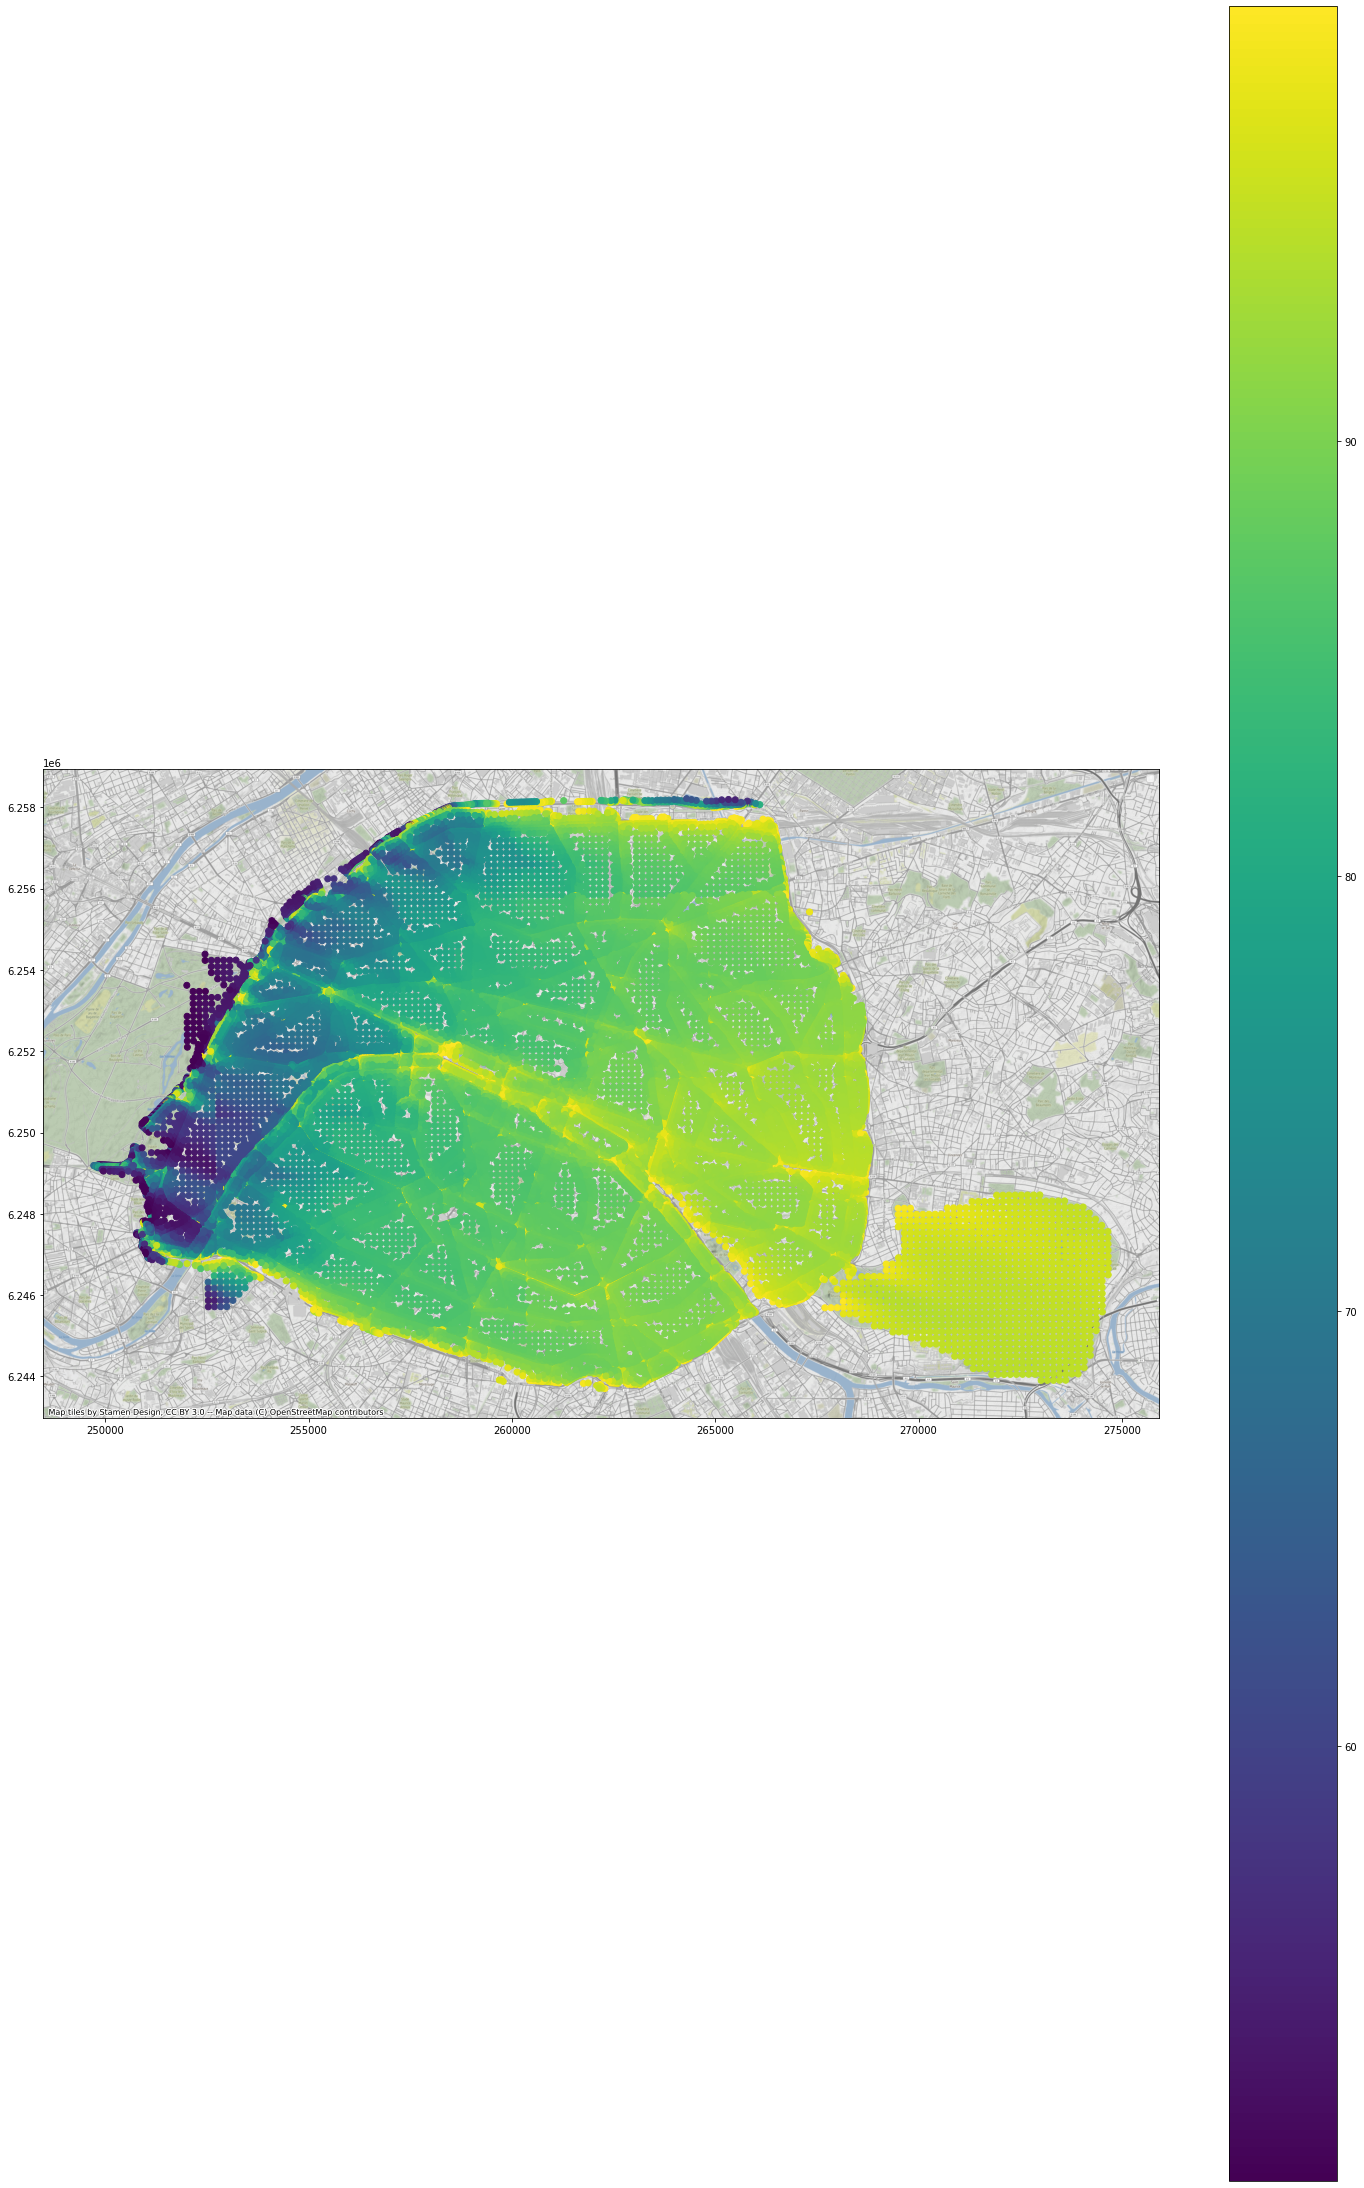

In [5]:
# Show one/several concentration field

#slice = np.arange(np.shape(mesh)[0], step=100)
slice = np.where((data[0,:] > 50) & (data[0,:] < 100))[0]

for k in range(1):
    df = pd.DataFrame({
         'lambert_x': mesh[slice,0],
         'lambert_y': mesh[slice,1],
         'NO2_u_star': data[k,slice].tolist()})
    gdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lambert_x, df.lambert_y), crs = "EPSG:2154")
    gdf = gdf.to_crs(epsg=3857) # Change to webmercator projection

    # Plot
    ax = gdf.plot(column='NO2_u_star', figsize=(25,40), legend=True) # ,
    cx.add_basemap(ax, zoom=15)
    ax.legend()

# Prepare training data for A-MSA

In [140]:
# Strategy
# Select no_samples snapshots from the 11k snapshots
# pick extract_size dofs (randomly)

# Export training data for A-MSA
no_samples = 100      # number of concentration snapshots to take 
extract_size = 100   # number of values to extract from each snapshot

Xin  = np.zeros((3, no_samples * extract_size))
Xout = np.zeros((1, no_samples * extract_size))

training_sample = np.sort(np.array(random.sample(range(ns),no_samples)))

for k in range(len(training_sample)):
    t = training_sample[k]/ns
    print('t={}'.format(t))
    rv = np.sort(np.array(random.sample(range(ndof), extract_size)))
    irange = np.arange(k*extract_size,(k+1)*extract_size)
    Xin[0, irange] = mesh[rv, 0]/xmax
    Xin[1, irange] = mesh[rv, 1]/ymax
    Xin[2, irange] = t * np.ones(extract_size)
    Xout[0, irange]   = data[training_sample[k], irange]/cmax
    
# Show shapes
Xin.shape, Xout.shape

t=0.0020005218752718102
t=0.003044272418891885
t=0.0042619813864486385
t=0.004609898234321997
t=0.02400626250326172
t=0.05549273723580064
t=0.05862398886666087
t=0.05914586413847091
t=0.07114899539010176
t=0.08080368791858746
t=0.10072192745933722
t=0.1088109941723928
t=0.10889797338436114
t=0.12603287814212402
t=0.13394798643124292
t=0.13751413412194485
t=0.17508915369226755
t=0.1756110289640776
t=0.17726363399147604
t=0.17952509350265286
t=0.18587457597634166
t=0.18744020179177176
t=0.1890928068191702
t=0.20901104635992
t=0.21866573888840568
t=0.23014699486822648
t=0.23980168739671218
t=0.24789075410976777
t=0.2514569018004697
t=0.2598938853613986
t=0.2734626424284596
t=0.27659389405931983
t=0.3140819344176742
t=0.31747412368443945
t=0.3330434026267722
t=0.3462642428459598
t=0.3500913281725668
t=0.37270592328433505
t=0.3749673827955119
t=0.38566582586761766
t=0.4035835435330956
t=0.40427937722884233
t=0.4530747151430808
t=0.4537705488388275
t=0.4541184656867009
t=0.4627294076715665
t

((3, 10000), (1, 10000))

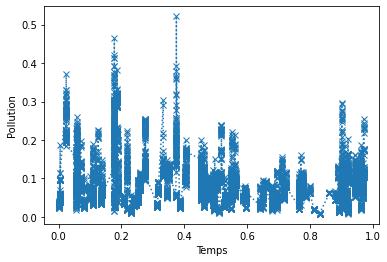

In [141]:
# Plot time serie
#plt.plot(Xin[2,::extract_size], Xout[0,::extract_size], ':x') # Show first dof @ eaach time
plt.plot(Xin[2,:], Xout[0,:], ':x') # Show everys dof values @ eaach time
plt.xlabel('Temps')
plt.ylabel('Pollution')
plt.show()

In [142]:
# Settings
settings = dict()
settings['maxNO2'] = cmax
settings['xmax'] = xmax
settings['ymax'] = ymax
settings['no_samples'] = no_samples
settings['extract_size'] = extract_size

In [143]:
settings

{'maxNO2': 929.007,
 'xmax': 660900.0,
 'ymax': 6867046.0,
 'no_samples': 100,
 'extract_size': 100}

In [144]:
# Save training data 
np.save('./pollution_data/settings.npy', settings)
np.save('./pollution_data/Xin.npy', Xin)
np.save('./pollution_data/Xout.npy', Xout)

# Prepare Test data for A-MSA

In [145]:
# Load sensor informations
dataset = pd.read_csv('./pollution_data/observation/Station_Airparif.csv', sep=',')
sf = pd.DataFrame(dataset)
stations_list = sf['Name'].tolist()
no_stations = len(stations_list)
dataset

,UID,Layer,Name,Geometry,Elevation,X,Y
0,1,Pointsspécifiques,ELYS,Point,2.4,649517.00,6863403.5
1,2,Pointsspécifiques,PA07,Point,4.3,648148.00,6862139.0
2,3,Pointsspécifiques,AUT,Point,2.3,645213.38,6861312.0
3,4,Pointsspécifiques,BONAP,Point,1.7,651158.50,6862003.5
4,5,Pointsspécifiques,OPERA,Point,1.7,651018.88,6863577.5
5,6,Pointsspécifiques,HAUS,Point,3.7,650884.38,6863905.5
6,7,Pointsspécifiques,PA04C,Point,3.4,652391.62,6862351.5
7,8,Pointsspécifiques,PA13,Point,2.6,653036.62,6858918.0
8,9,Pointsspécifiques,CELES,Point,1.2,653046.19,6861587.5
9,10,Pointsspécifiques,PA18,Point,15.4,652095.62,6865938.0


In [146]:
# Load observation from sensors only
cols = ['date','heure'] + stations_list
df = pd.read_csv('./pollution_data/observation/20160701_20200701-NO2_auto.csv', sep=';', skiprows=[1])
full_data = pd.DataFrame(df, columns=cols)

In [147]:
# Remove n/d rows 
full_data = full_data.replace('n/d', np.nan).dropna()
full_data

,date,heure,ELYS,PA07,AUT,BONAP,OPERA,HAUS,PA04C,PA13,CELES,PA18,BASCH,PA15L,PA12,BP_EST,SOULT
0,01/07/2016,1,22,10,36,17,38,33,14,9,16,13,28,5,17,49,32
1,01/07/2016,2,13,8,23,21,15,17,10,5,8,8,18,3,12,38,24
2,01/07/2016,3,12,6,27,31,13,13,9,4,7,6,14,2,9,28,14
3,01/07/2016,4,10,7,42,10,17,18,6,5,7,6,17,2,8,22,11
4,01/07/2016,5,26,12,78,17,39,29,14,12,18,10,35,5,12,22,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17307,22/06/2018,4,22,21,83,21,32,19,18,12,44,33,49,17,16,51,32
17308,22/06/2018,5,39,29,90,35,49,39,28,20,81,44,62,27,25,70,47
17309,22/06/2018,6,50,52,74,54,72,50,40,32,107,48,84,49,33,84,64
17310,22/06/2018,7,57,86,78,49,71,42,41,28,109,41,81,48,35,66,56


In [148]:
import datetime as dt

# Reference time based on the earliest snapshot time
fmt = '%d/%m/%Y %H %M'
min_dt = '06/07/2017 0 0'
max_dt = '26/11/2018 23 0'

def time_to_num(str_date, hour):
    
    s = 0.
    dt_min = dt.datetime.strptime(min_dt, fmt)
    dt_max = dt.datetime.strptime(max_dt, fmt)
    
    str_date += ' ' + str(hour) + ' 00'
    dt_date = dt.datetime.strptime(str_date, fmt)
    #print('Date requested: {}/{}/{} {}:{}'.format(dt_date.day, dt_date.month, dt_date.year, dt_date.hour, dt_date.minute))
    
    assert dt_date >= dt_min
    assert dt_date <= dt_max
    
    max_seconds = (dt_max - dt_min).total_seconds()
    
    period = dt_date - dt_min
    s = period.total_seconds()
        
    return s/max_seconds

# test
s=time_to_num('26/11/2018', 23)
s

1.0

In [149]:
# Select rows from 06/07/2017
full_data = full_data.iloc[2322:]

In [150]:
# La convention h=24 est embêtante... on vire tous les temps à heure=24
skiph24 = full_data['heure'] < 24
full_data = full_data[skiph24]

In [151]:
# Merge date and time columns into datetime rescaled in [0,1]
# where 0 = first snapshot in dataset
# and   1 = last snapshot in dataset
full_data['datetime'] = full_data.apply(lambda r : time_to_num(r['date'], r['heure']), axis=1)
del full_data['date']
del full_data['heure']
full_data

,ELYS,PA07,AUT,BONAP,OPERA,HAUS,PA04C,PA13,CELES,PA18,BASCH,PA15L,PA12,BP_EST,SOULT,datetime
8889,93,64,137,100,140,111,81,68,99,77,140,56,72,136,101,0.000819
8890,89,59,136,104,142,135,81,79,118,76,140,52,74,152,99,0.000901
8891,98,47,144,108,166,154,71,46,136,72,168,34,46,170,63,0.000982
8893,125,53,146,116,165,163,61,37,160,80,175,38,45,197,64,0.001146
8894,91,44,147,79,178,189,65,29,134,41,243,28,26,178,40,0.001228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17307,22,21,83,21,32,19,18,12,44,33,49,17,16,51,32,0.689971
17308,39,29,90,35,49,39,28,20,81,44,62,27,25,70,47,0.690053
17309,50,52,74,54,72,50,40,32,107,48,84,49,33,84,64,0.690135
17310,57,86,78,49,71,42,41,28,109,41,81,48,35,66,56,0.690217


# Extract time serie @ each station

In [152]:
# Time steps
time=full_data['datetime'].to_numpy(dtype=np.float64)
station_list = full_data.columns.to_list()
del station_list[-1] # remove 'datetime'
print('time snapshots={}, no. station={}'.format(time.size, len(station_list)))

time snapshots=4585, no. station=15


In [153]:
# Generation of the test set based only on the station ELYS 
for i,station in enumerate(station_list):
    print('Treating sation ' + station)
    cStation=full_data[station].to_numpy(dtype=np.float64)

    X0_test = np.ones((3,cStation.size))
    X0_test[0,:] = dataset.iloc[i]['X']/xmax
    X0_test[1,:] = dataset.iloc[i]['Y']/ymax
    X0_test[2,:] = time
    XT_test = np.array(cStation/cmax, ndmin=2)
    
    # Save in binary form
    np.save('./pollution_data/observation/Xin_test_'+station+'.npy', X0_test)
    np.save('./pollution_data/observation/Xout_test_'+station+'.npy', XT_test)

Treating sation ELYS
Treating sation PA07
Treating sation AUT
Treating sation BONAP
Treating sation OPERA
Treating sation HAUS
Treating sation PA04C
Treating sation PA13
Treating sation CELES
Treating sation PA18
Treating sation BASCH
Treating sation PA15L
Treating sation PA12
Treating sation BP_EST
Treating sation SOULT


# Extract n measures at specific times

In [154]:
# Extract 500 rows of the full data
no_measures = 100
time_measures = np.sort(np.array(random.sample(range(time.size),no_measures)))
extract_data = full_data.iloc[time_measures].to_numpy(dtype=np.float64)

In [155]:
# Data to export
X0_test = np.ones((3, no_stations * no_measures))
XT_test = np.ones((1, no_stations * no_measures))
for c,it in enumerate(time_measures):
    #print('Treating time {} {}/{}'.format(it, c, len(time_measures)-1))
    for k,station in enumerate(station_list):
        X0_test[0, c*len(station_list) + k] = dataset.iloc[k]['X']/xmax
        X0_test[1, c*len(station_list) + k] = dataset.iloc[k]['Y']/ymax
        X0_test[2, c*len(station_list) + k] = extract_data[c, len(station_list)] # temps
        XT_test[0, c*len(station_list) + k] = extract_data[c,k]/cmax
        
# Check Shapes
X0_test.shape, XT_test.shape

((3, 1500), (1, 1500))

In [156]:
# Save
np.save('./pollution_data/observation/Xin_allstations.npy',  X0_test)
np.save('./pollution_data/observation/Xout_allstations.npy', XT_test)

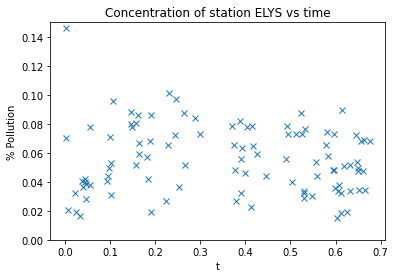

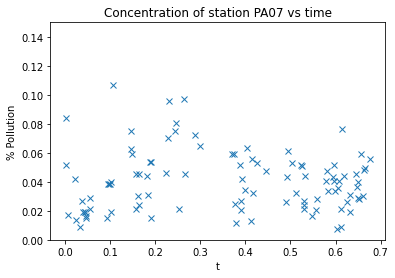

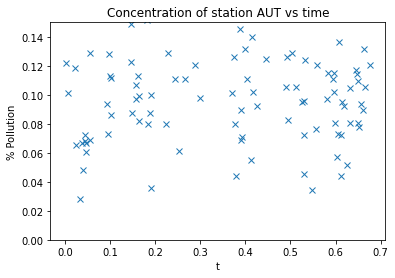

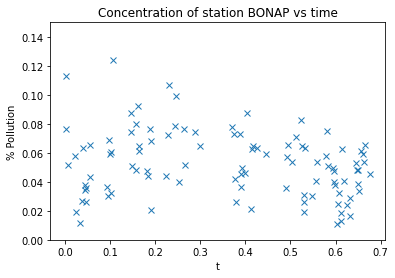

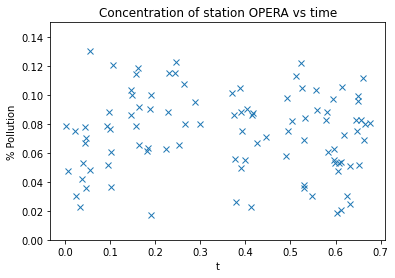

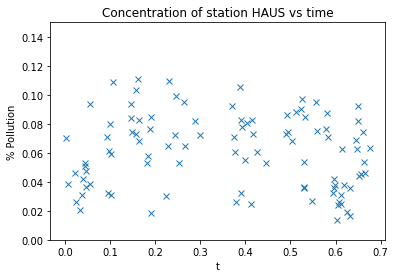

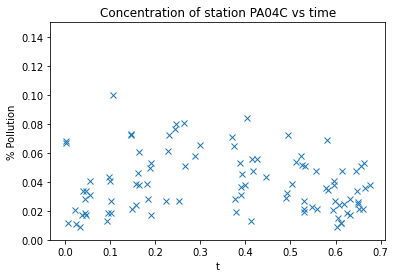

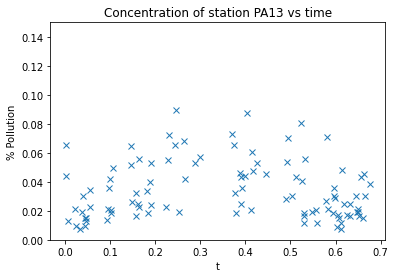

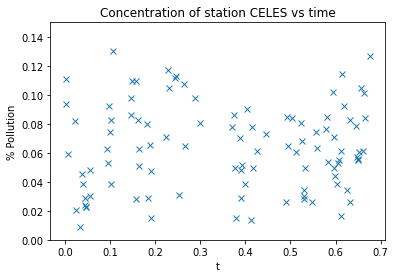

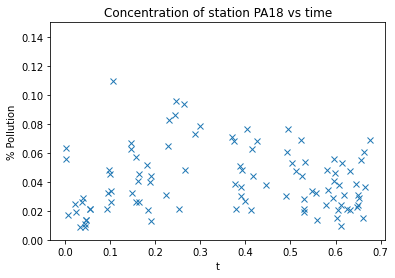

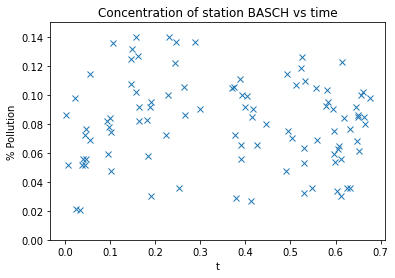

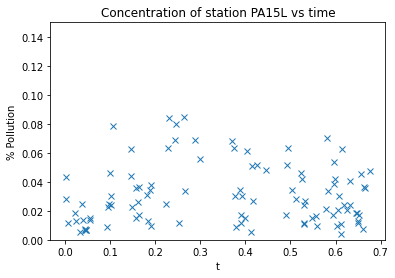

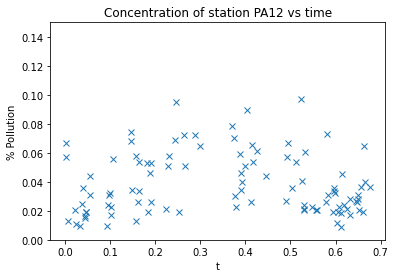

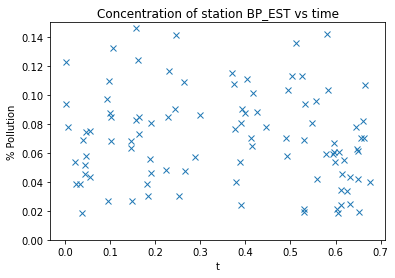

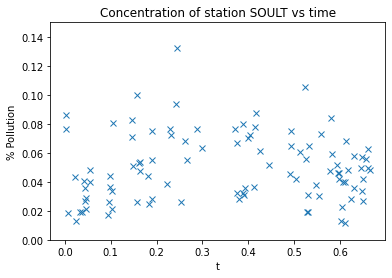

In [157]:
# Check : Plot of the concentration vs time for each station
# station_number = 2  # station number : from 0 to 14
for station_number in range(no_stations):
    tmax = -1
    assert station_number < no_stations
    assert tmax < no_stations * no_measures
    plt.plot(X0_test[2, station_number:tmax:no_stations], XT_test[0,station_number:tmax:no_stations], 'x')
    plt.title('Concentration of station ' + station_list[station_number] + ' vs time')
    plt.ylim(0, 0.15)
    plt.xlabel('t')
    plt.ylabel('% Pollution')
    plt.show()